In [4]:
pip install pypots pykalman properscoring sktime iisignature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 968.1 kB/s eta 0:00:000:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.5 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.1/564.1 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.9/36.9 MB 43.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 7.9 MB/s eta 0:00:00
  Created wheel for iisignature: filename=iisignature-0.24-cp310-cp310-linux_x86_64.whl size=3245484 sha256=332e4c347de12bb97b26a9fe1e427aebd55be60ac99e4f755eade55ffafbb9fb
  Stored in directory: /root/.cache/pip/wheels/c8/13/d1/42e1aa7f8a8e1189360df53c461f0e13f43e0d2170ef16d349
Successfully built iisignature
Note: you may need to restart the kernel to use updated packages.


In [5]:
%reload_ext autoreload
%autoreload 2


import numpy as np
import random
import torch
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from pykalman import KalmanFilter
from pypots.imputation import CSDI
from pypots.optim import Adam
from properscoring import crps_ensemble
from sktime.performance_metrics.forecasting.probabilistic import CRPS
import seaborn as sns
import iisignature
import copy

/usr/local/lib/python3.10/dist-packages/pypots/nn/modules/reformer/local_attention.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return autocast(**kwargs)


In [6]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
def generate_ou_process(n_samples, n_steps, mu=0, theta=0.15, sigma=0.3, anomaly=0):
    dt = 1.0
    timeline = np.zeros((n_steps))
    X = np.zeros((n_samples, n_steps))
    X[:, 0] = mu  # начальные условия
    for t in range(1, n_steps):
        dX = theta * (mu - X[:, t-1]) * dt + sigma * np.random.normal(size=n_samples) * np.sqrt(dt)
        X[:, t] = X[:, t-1] + dX
        timeline[t] = dt + timeline[t-1]
    if anomaly:
        for sample in range(0, n_samples) :
            anomaly_time = np.random.randint(0, n_steps)
            X[sample, anomaly_time] += np.random.choice([1, -1]) * anomaly # аномалия +- 5 сигм

    return X, timeline

In [8]:
def normalize_arr(arr):
    arr = np.array(arr, dtype=float)
    mean = np.mean(arr)
    std_dev = np.std(arr)

    return (arr - mean) / std_dev

In [9]:
def calc_sig_window(window, path, timeline, sig_level, dimension):
    # assert(len(path) % window == 0)
    mean_sig = np.zeros(iisignature.siglength(dimension, sig_level)) 
    for i in range(int(len(path)/window)):
        last_border = (i+1)*window
        if last_border > len(path):
            last_border = len(path)
        mean_sig += iisignature.sig(np.column_stack((timeline[i*window:(i+1)*window], path[i*window:(i+1)*window])), sig_level)
    mean_sig /= int(len(path)/window)
    return mean_sig

In [10]:
def inject_sin(base, start, end, periods=np.random.randint(-4,4) / 2, noise_rate=np.random.uniform(0,1), sin_ampl=0.5):
    dt = periods * 2 * np.pi / (end - start + 1) 
    arr = base.copy()
    for t in range(start, end + 1):
        noise = np.random.normal(0, 1)
        if noise < -1:
            noise = -1
        if noise > 1:
            noise = 1
        arr[t] = sin_ampl * np.sin((t - start + 1) * dt) + noise * noise_rate
    return arr

In [11]:
def sig_data(X, sig_level, timeline) :
    (n_samples, n_steps, n_features) = X.shape
    sig_length = iisignature.siglength(n_features + 1, sig_level)
    signatures = []
    for i in range(n_samples):
        signatures.append(iisignature.sig(np.column_stack((timeline, X[i, :, :])), sig_level))
    signatures = np.insert(signatures, 0, 1, axis=1)
    
    return signatures

In [12]:
def sig_data_window(X, sig_level, timeline, window_size):
    (n_samples, n_steps, n_features) = X.shape
    sig_length = iisignature.siglength(n_features + 1, sig_level)
    signatures = []
    for i in range(n_samples):
        signatures.append(calc_sig_window(window_size, X[i, :, :], timeline, sig_level, n_features + 1))
    signatures = np.insert(signatures, 0, 1, axis=1)
    return signatures

In [13]:
def introduce_missigness(X, missing_rate=15, missing_start = -1):
    num_samples, n_steps, n_features = X.shape
    X_missing = X.copy()
    for i in range(num_samples):
        if (missing_start == -1) :
            missing_start = np.random.randint(0, n_steps - missing_rate + 1)
        X_missing[i, missing_start: missing_start + missing_rate, :] = np.nan
    return X_missing

In [74]:
def first_nan(arr):
    for i in range(len(arr)):
        if np.isnan(arr[i]):
            return i

In [19]:
n_samples = 1000
n_steps = 500
mu = 0.0
theta = 0.15
sigma = 0.3 
sig_level = 5
window = 100

In [42]:
X, timeline = generate_ou_process(1, n_steps, mu, theta, sigma, anomaly=0)
X = X.reshape(X.shape[0], X.shape[1], 1)

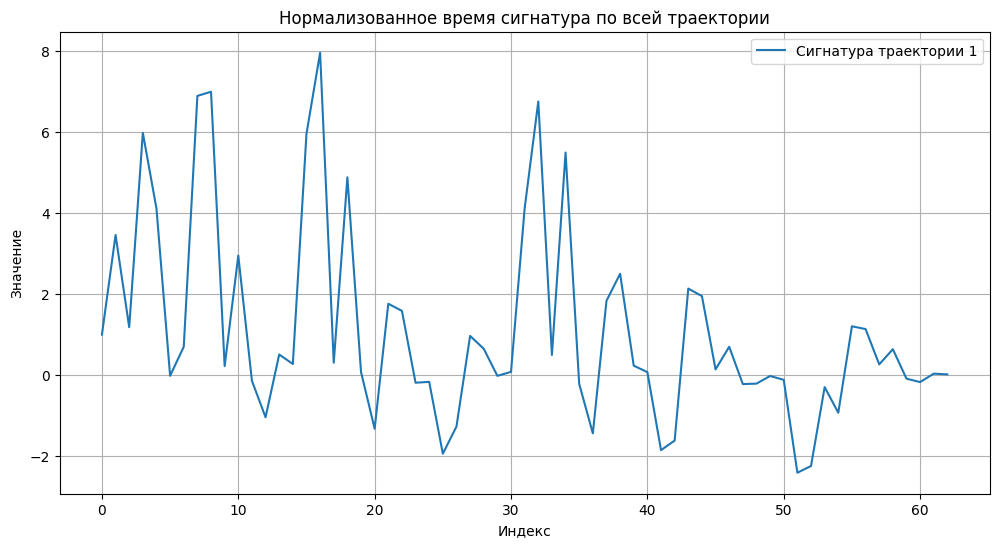

In [43]:
signatures = sig_data(X, sig_level, normalize_arr(timeline))
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Нормализованное время сигнатура по всей траектории")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

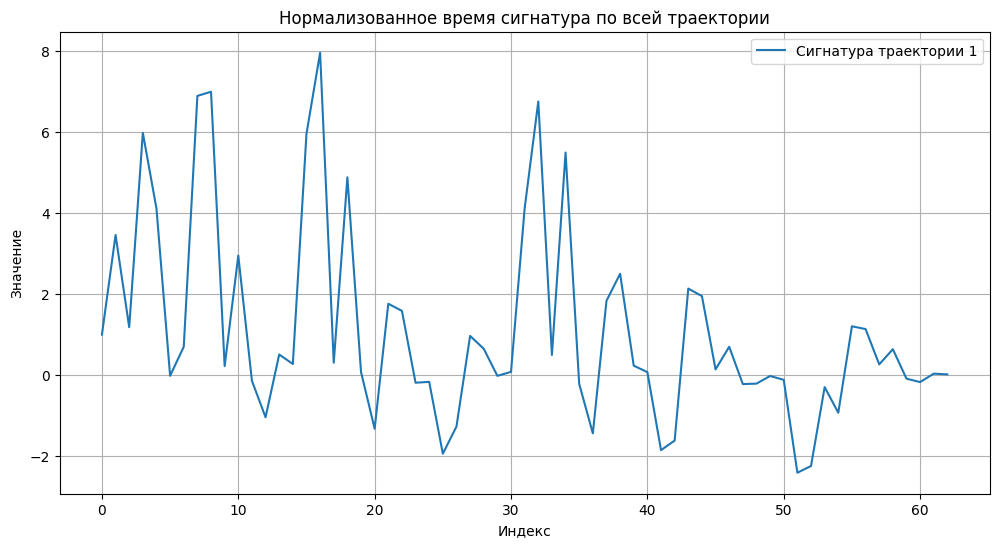

In [44]:
signatures = sig_data_window(X, sig_level, normalize_arr(timeline), n_steps)
plt.figure(figsize=(12, 6))
for i, signature in enumerate(signatures):
    plt.plot(signature, label=f"Сигнатура траектории {i+1}")
plt.title("Нормализованное время сигнатура по всей траектории")
# plt.ylim(-25*10**3,175*10**3)
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

In [51]:
X_anomaly_base, timeline = generate_ou_process(1, 100, mu, theta, sigma, anomaly=0)
sinus_window = 32

In [54]:
X_anomaly = []
for i in range(X_anomaly_base.shape[0]):
    start = np.random.randint(0, X_anomaly_base.shape[1] - sinus_window + 1)
    print(start)
    X_anomaly.append(inject_sin(X_anomaly_base[i], start, start + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
X_anomaly = np.array(X_anomaly)

46


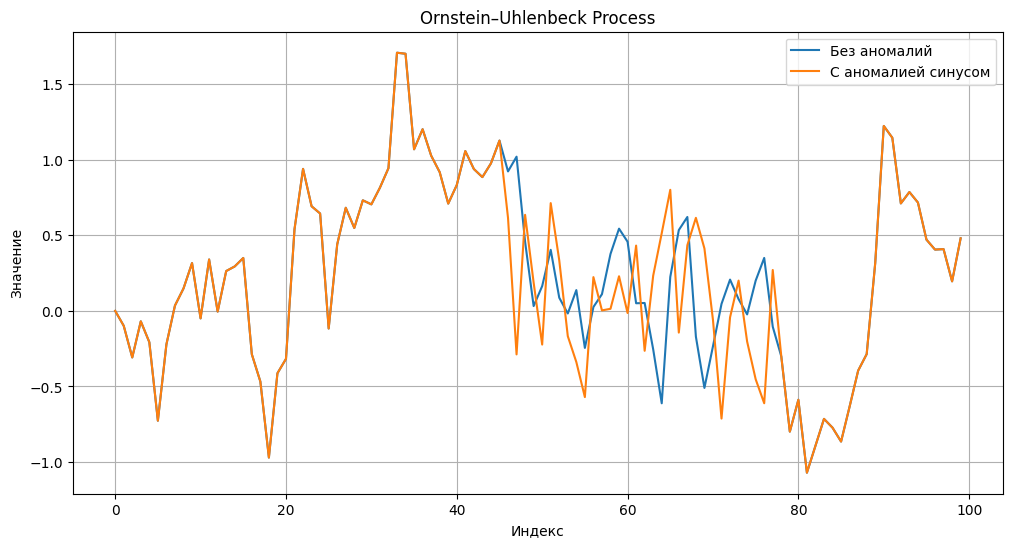

In [55]:
plt.figure(figsize=(12, 6))
plt.title("Ornstein–Uhlenbeck Process")
plt.plot(X_anomaly_base[0], label=f"Без аномалий")
plt.plot(X_anomaly[0], label=f"С аномалией синусом")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

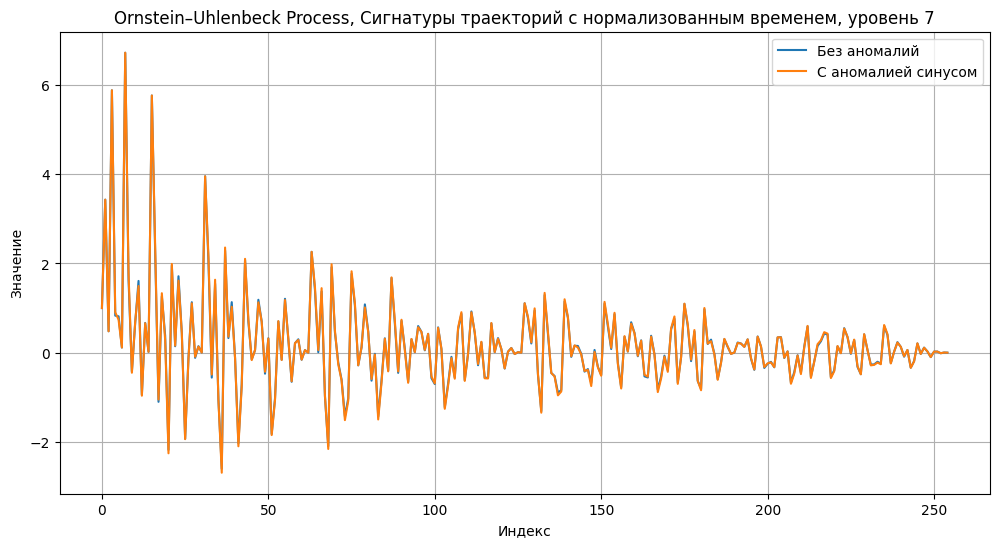

In [64]:
sig_level = 7
sig_base = np.insert(iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly_base[0])), sig_level), 0, 1)
sig_anom = np.insert(iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[0])), sig_level), 0, 1)
plt.figure(figsize=(12, 6))
plt.title(f"Ornstein–Uhlenbeck Process, Сигнатуры траекторий c нормализованным временем, уровень {sig_level}")
plt.plot(sig_base, label=f"Без аномалий")
plt.plot(sig_anom, label=f"С аномалией синусом")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

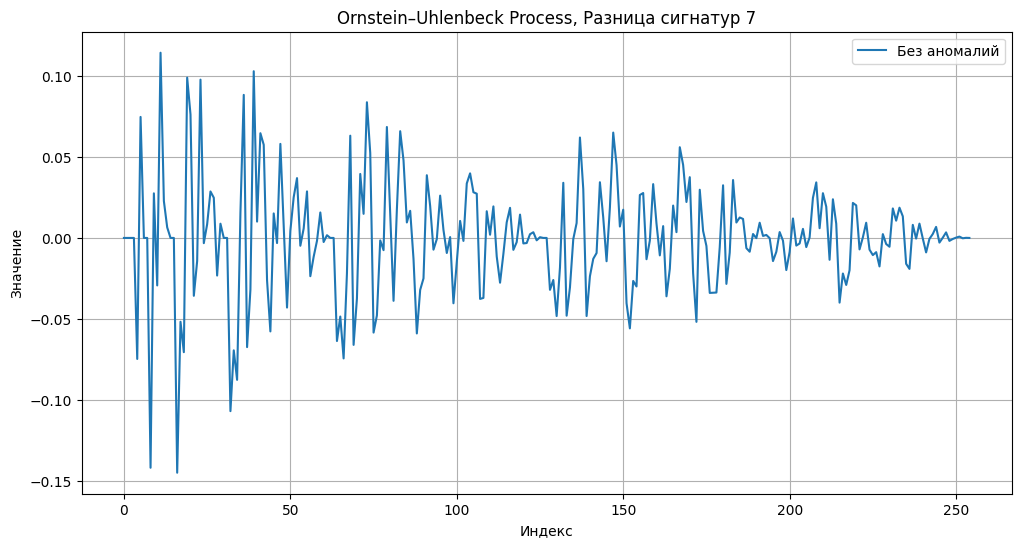

In [68]:
plt.figure(figsize=(12, 6))
plt.title(f"Ornstein–Uhlenbeck Process, Разница сигнатур {sig_level}")
plt.plot(sig_base - sig_anom, label=f"Без аномалий")
plt.xlabel("Индекс")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.show()

In [71]:
def train_ThreeLayerNN(model_params, X, y):
    num_epochs = model_params["num_epochs"]
    lr = model_params["lr"]
    batch_size = model_params["batch_size"]
    test_size = model_params["test_size"]
    hidden_size = model_params["hidden_size"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class ThreeLayerNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ThreeLayerNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x

    input_size = X.shape[1]
    hidden_size = hidden_size
    output_size = 1
    model = ThreeLayerNN(input_size, hidden_size, output_size)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_epoch = 0
    best_loss = 10**10
    best_metrics = {}

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            all_outputs = []
            all_labels = []
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                predicted = (outputs > 0.5).float()
                all_outputs.extend(outputs.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())

            all_outputs = np.array(all_outputs).flatten()
            all_labels = np.array(all_labels).flatten()

            accuracy = 100 * (all_labels == (all_outputs > 0.5)).mean()
            precision = 100 * precision_score(all_labels, all_outputs > 0.5)
            recall = 100 * recall_score(all_labels, all_outputs > 0.5)
            f1 = 100 * f1_score(all_labels, all_outputs > 0.5)
            roc_auc = 100 * roc_auc_score(all_labels, all_outputs)
            conf_matrix = confusion_matrix(all_labels, all_outputs > 0.5)

            # Сохранение лучших метрик
            if best_loss > loss:
                best_epoch = epoch
                best_loss = loss
                best_metrics = {
                    "accuracy": accuracy,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1,
                    "roc_auc": roc_auc                }

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Roc-auc: {roc_auc:.2f}%, F1-score: {f1:.2f}")

    print(f"Минимум функции потерь на эпохе {best_epoch+1}, F1-score: {best_metrics['f1_score']:.2f}%, Roc-auc: {best_metrics['roc_auc']:.2f}%, Accuracy: {best_metrics['accuracy']:.2f}%, Precision: {best_metrics['precision']:.2f}%, Recall: {best_metrics['recall']:.2f}%")
    return best_metrics

In [72]:
model_params = {
    "num_epochs": 30,
    "lr": 0.003,
    "batch_size": 32,
    "test_size": 0.2,
    "hidden_size": 64,
}

num_epochs = model_params["num_epochs"]
lr = model_params["lr"]
batch_size = model_params["batch_size"]
test_size = model_params["test_size"]
hidden_size = model_params["hidden_size"]

In [73]:
csdi_params = {
    "n_steps":500,
    "n_features":1,
    "n_layers":2,
    "n_heads":4,
    "n_channels":64,
    "d_time_embedding":16,
    "d_feature_embedding":16,
    "d_diffusion_embedding":16,
    "is_unconditional":False,
    "target_strategy":"mix",
    "n_diffusion_steps":100,
    "schedule":"linear",
    "beta_start":0.001,
    "beta_end":0.02,
    "batch_size":32,
    "epochs":100,
    #"patience":10,
    # "device":None, # Пусть автоматически выбирает устройство
    "saving_path": 'CSDI',
    "model_saving_strategy":"better",
    #"verbose":True
}

In [54]:
n_samples = 100
n_steps = 500
mu = 0.0
theta = 0.15
sigma = 0.3 
sig_level = 5
window = 100

In [16]:
model = CSDI(
    n_steps=n_steps,
    n_features=csdi_params["n_features"],
    n_layers=csdi_params["n_layers"],
    n_heads=csdi_params["n_heads"],
    n_channels=csdi_params["n_channels"],
    d_time_embedding=csdi_params["d_time_embedding"],
    d_feature_embedding=csdi_params["d_feature_embedding"],
    d_diffusion_embedding=csdi_params["d_diffusion_embedding"],
    is_unconditional=csdi_params["is_unconditional"],
    target_strategy=csdi_params["target_strategy"],
    n_diffusion_steps=csdi_params["n_diffusion_steps"],
    schedule=csdi_params["schedule"],
    beta_start=csdi_params["beta_start"],
    beta_end=csdi_params["beta_end"],
    batch_size=csdi_params["batch_size"],
    epochs=csdi_params["epochs"],
    #patience=csdi_params["patience"],
    # device=csdi_params["device"], # Пусть автоматически выбирает устройство
    saving_path=csdi_params["saving_path"],
    model_saving_strategy=csdi_params["model_saving_strategy"],
    #verbose=csdi_params["verbose"]
)
X_ou_train, _ = generate_ou_process(1000, n_steps, mu, theta, sigma, anomaly=0)
X_ou_train = X_ou_train.reshape(X_ou_train.shape[0], X_ou_train.shape[1], 1)
data = {"X": X_ou_train}
model.fit(data)

2025-03-04 15:13:37 [INFO]: No given device, using default device: cuda
2025-03-04 15:13:37 [INFO]: Model files will be saved to CSDI/20250304_T151337
2025-03-04 15:13:37 [INFO]: Tensorboard file will be saved to CSDI/20250304_T151337/tensorboard
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-03-04 15:13:37 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 150,001
2025-03-04 15:13:40 [INFO]: Epoch 001 - training loss (default): 0.6717
2025-03-04 15:13:40 [INFO]: Saved the model to CSDI/20250304_T151337/CSDI_epoch1_loss0.6717.pypots
2025-03-04 15:13:41 [INFO]: Epoch 002 - training loss (default): 0.5534
2025-03-04 15:13:41 [INFO]: Saved the model to CSDI/20250304_T151337/CSDI_epoch2_loss0.5534.pypots
2025-03-04

NameError: name 'missing_rate' is not defined

In [20]:
missing_rate = 100
X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), 500, mu, theta, sigma, anomaly=0)
X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)

X_ou_test_missing = introduce_missigness(X_noanomaly, missing_rate)
X_ou_test_missing = X_ou_test_missing.reshape(X_ou_test_missing.shape[0], X_ou_test_missing.shape[1], 1)
data_missing = {"X": X_ou_test_missing}

predict = model.predict(data_missing, n_sampling_times=10)

In [61]:
predict['imputation'][:, :, :, :].reshape(-1, 500).shape

(700, 500)

In [48]:
sinus_window = missing_rate
X_anomaly = list()
for i in range(X_ou_test_missing.shape[0]):
    start = first_nan(X_ou_test_missing[i, :, 0])
    X_anomaly.append(inject_sin(X_ou_test_missing[i], start, start + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
X_anomaly = np.array(X_anomaly)

In [50]:
X_anomaly.shape

(70, 500, 1)

In [42]:
print(first_nan(X_ou_test_missing[0, :, 0]))

230


In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

In [78]:
def train_sin_anomaly_no_signatures(n_steps_arr):
    metrics_dict = {
                        "accuracy": list(),
                        "precision": list(),
                        "recall": list(),
                        "f1_score": list(),
                        "roc_auc": list()
    }

    metrics_dict_all = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }

    metrics_dict_window = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }
    
    for n_steps in n_steps_arr:
        model_CSDI= CSDI(
            n_steps=n_steps,
            n_features=csdi_params["n_features"],
            n_layers=csdi_params["n_layers"],
            n_heads=csdi_params["n_heads"],
            n_channels=csdi_params["n_channels"],
            d_time_embedding=csdi_params["d_time_embedding"],
            d_feature_embedding=csdi_params["d_feature_embedding"],
            d_diffusion_embedding=csdi_params["d_diffusion_embedding"],
            is_unconditional=csdi_params["is_unconditional"],
            target_strategy=csdi_params["target_strategy"],
            n_diffusion_steps=csdi_params["n_diffusion_steps"],
            schedule=csdi_params["schedule"],
            beta_start=csdi_params["beta_start"],
            beta_end=csdi_params["beta_end"],
            batch_size=csdi_params["batch_size"],
            epochs=csdi_params["epochs"],
            #patience=csdi_params["patience"],
            # device=csdi_params["device"], # Пусть автоматически выбирает устройство
            saving_path=csdi_params["saving_path"],
            model_saving_strategy=csdi_params["model_saving_strategy"],
            #verbose=csdi_params["verbose"]
        )
        X_ou_train, _ = generate_ou_process(1000, n_steps, mu, theta, sigma, anomaly=0)
        X_ou_train = X_ou_train.reshape(X_ou_train.shape[0], X_ou_train.shape[1], 1)
        model_CSDI.fit({"X": X_ou_train})
        
        missing_rate = int(n_steps/5)
        X_noanomaly, timeline = generate_ou_process(n_samples, n_steps, mu, theta, sigma, anomaly=0)
        X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        
        X_ou_test_missing = introduce_missigness(X_noanomaly, missing_rate)
        X_ou_test_missing = X_ou_test_missing.reshape(X_ou_test_missing.shape[0], X_ou_test_missing.shape[1], 1)
        
        predict = model_CSDI.predict({"X": X_ou_test_missing}, n_sampling_times=100)["imputation"] # shape (100, 100, 500, 1) 100 - количество созданных возможных реализаций распределения
        X_noanomaly = predict.reshape(-1, n_steps)
        print("PREDICTS DONE")
        sinus_window = missing_rate
        X_anomaly = list()
        for i in range(X_ou_test_missing.shape[0]):
            start = first_nan(X_ou_test_missing[i, :, 0])
            X_anomaly.append(inject_sin(X_ou_test_missing[i, :, 0], start, start + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        X_anomaly = np.array(X_anomaly)
        
        y_noanomaly = np.zeros(X_noanomaly.shape[0])
        y_anomaly = np.ones(X_anomaly.shape[0])
        print(X_noanomaly.shape, X_anomaly.shape)
        X = np.vstack((X_noanomaly, X_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        
        print(f"Размер процесса: {n_steps}")
        print("НЕОБРАБОТАННЫЕ СИГНАТУРОЙ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict["accuracy"].append(metrics["accuracy"])
        metrics_dict["precision"].append(metrics["precision"])
        metrics_dict["recall"].append(metrics["recall"])
        metrics_dict["f1_score"].append(metrics["f1_score"])
        metrics_dict["roc_auc"].append(metrics["roc_auc"])

        
        X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        X_anomaly = X_anomaly.reshape(X_anomaly.shape[0], X_anomaly.shape[1], 1)
        
        # обработка сигнатурой
        signatures_no_anomaly = sig_data(X_noanomaly, sig_level, normalize_arr(timeline))
        signatures_with_anomaly = sig_data(X_anomaly, sig_level, normalize_arr(timeline))
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print("СИГНАТУРА ПО ВСЕМУ ПРОЦЕССУ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_all["accuracy"].append(metrics["accuracy"])
        metrics_dict_all["precision"].append(metrics["precision"])
        metrics_dict_all["recall"].append(metrics["recall"])
        metrics_dict_all["f1_score"].append(metrics["f1_score"])
        metrics_dict_all["roc_auc"].append(metrics["roc_auc"])

        # сигнатура по окну
        signatures_with_anomaly = sig_data_window(X_anomaly, sig_level, normalize_arr(timeline), missing_rate)
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print(f"СИГНАТУРА ПО ОКНУ {missing_rate}")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_window["accuracy"].append(metrics["accuracy"])
        metrics_dict_window["precision"].append(metrics["precision"])
        metrics_dict_window["recall"].append(metrics["recall"])
        metrics_dict_window["f1_score"].append(metrics["f1_score"])
        metrics_dict_window["roc_auc"].append(metrics["roc_auc"])
        
    return metrics_dict, metrics_dict_all, metrics_dict_window

In [72]:
X_noanomaly.shape, X_anomaly.shape

((70, 500, 1), (70, 500, 1))

In [ ]:
n_steps_arr = [250, 500, 1000, 2000]

In [70]:
def calculate_average_metrics(data):
    agg = {key: np.zeros(len(values)) for key, values in data[0].items()}
    
    for i in range(len(data)):
        for key, values in data[i].items():
            for j in range(len(values)):
                agg[key][j] += values[j]
                
    for key, values in agg.items():
        for j in range(len(values)):
            values[j] /= len(data)
            
    return agg

In [ ]:
plt.figure(figsize=(16, 8))
n_steps_arr = [250, 500, 1000, 2000, 4000]
avg_no, avg_sign, avg_win = calculate_average_metrics(res)
for key, arr in avg_no.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"без сигнатур{i}, {key}")
for key, arr in avg_sign.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему {i}, {key}")
plt.title("Без использования сигнатур")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
n_samples = 500
n_steps = 250
mu = 0.0
theta = 0.15
sigma = 0.3 
sig_level = 5
window = 100

In [26]:
def train_sin_anomaly_no_signatures(n_steps_arr):
    metrics_dict = {
                        "accuracy": list(),
                        "precision": list(),
                        "recall": list(),
                        "f1_score": list(),
                        "roc_auc": list()
    }

    metrics_dict_all = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }

    metrics_dict_window = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }
    
    for n_steps in n_steps_arr:
        model_CSDI= CSDI(
            n_steps=n_steps,
            n_features=csdi_params["n_features"],
            n_layers=csdi_params["n_layers"],
            n_heads=csdi_params["n_heads"],
            n_channels=csdi_params["n_channels"],
            d_time_embedding=csdi_params["d_time_embedding"],
            d_feature_embedding=csdi_params["d_feature_embedding"],
            d_diffusion_embedding=csdi_params["d_diffusion_embedding"],
            is_unconditional=csdi_params["is_unconditional"],
            target_strategy=csdi_params["target_strategy"],
            n_diffusion_steps=csdi_params["n_diffusion_steps"],
            schedule=csdi_params["schedule"],
            beta_start=csdi_params["beta_start"],
            beta_end=csdi_params["beta_end"],
            batch_size=csdi_params["batch_size"],
            epochs=csdi_params["epochs"],
            #patience=csdi_params["patience"],
            # device=csdi_params["device"], # Пусть автоматически выбирает устройство
            saving_path=csdi_params["saving_path"],
            model_saving_strategy=csdi_params["model_saving_strategy"],
            #verbose=csdi_params["verbose"]
        )
        X_ou_train, _ = generate_ou_process(1000, n_steps, mu, theta, sigma, anomaly=0)
        X_ou_train = X_ou_train.reshape(X_ou_train.shape[0], X_ou_train.shape[1], 1)
        model_CSDI.fit({"X": X_ou_train})
        
        missing_rate = int(n_steps/5)
        X_noanomaly, timeline = generate_ou_process(n_samples, n_steps, mu, theta, sigma, anomaly=0)
        X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        
        X_ou_test_missing = introduce_missigness(X_noanomaly, missing_rate)
        X_ou_test_missing = X_ou_test_missing.reshape(X_ou_test_missing.shape[0], X_ou_test_missing.shape[1], 1)
        
        predict = model_CSDI.predict({"X": X_ou_test_missing}, n_sampling_times=14)["imputation"] # shape (100, 10, 500, 1) 100 - количество созданных возможных реализаций распределения
        X_noanomaly = predict.reshape(-1, n_steps)
        print("PREDICTS DONE")
        sinus_window = missing_rate
        X_anomaly = list()
        for i in range(X_ou_test_missing.shape[0]):
            start1 = first_nan(X_ou_test_missing[i, :, 0])
            for s in range(3):
                start2 = np.random.randint(0, n_steps - sinus_window + 1)
                X_anomaly.append(inject_sin(X_ou_test_missing[i, :, 0], start1, start1 + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
                X_anomaly.append(inject_sin(X_ou_train[i, :, 0], start2, start2 + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        X_anomaly = np.array(X_anomaly)
        
        y_noanomaly = np.zeros(X_noanomaly.shape[0])
        y_anomaly = np.ones(X_anomaly.shape[0])
        print(X_noanomaly.shape, X_anomaly.shape)
        X = np.vstack((X_noanomaly, X_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        
        print(f"Размер процесса: {n_steps}")
        print("НЕОБРАБОТАННЫЕ СИГНАТУРОЙ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict["accuracy"].append(metrics["accuracy"])
        metrics_dict["precision"].append(metrics["precision"])
        metrics_dict["recall"].append(metrics["recall"])
        metrics_dict["f1_score"].append(metrics["f1_score"])
        metrics_dict["roc_auc"].append(metrics["roc_auc"])

        
        X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        X_anomaly = X_anomaly.reshape(X_anomaly.shape[0], X_anomaly.shape[1], 1)
        
        # обработка сигнатурой
        signatures_no_anomaly = sig_data(X_noanomaly, sig_level, normalize_arr(timeline))
        signatures_with_anomaly = sig_data(X_anomaly, sig_level, normalize_arr(timeline))
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print("СИГНАТУРА ПО ВСЕМУ ПРОЦЕССУ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_all["accuracy"].append(metrics["accuracy"])
        metrics_dict_all["precision"].append(metrics["precision"])
        metrics_dict_all["recall"].append(metrics["recall"])
        metrics_dict_all["f1_score"].append(metrics["f1_score"])
        metrics_dict_all["roc_auc"].append(metrics["roc_auc"])

        # сигнатура по окну
        window_size =int(n_steps/5 * 2)
        signatures_no_anomaly = sig_data_window(X_noanomaly, sig_level, normalize_arr(timeline), window_size)
        signatures_with_anomaly = sig_data_window(X_anomaly, sig_level, normalize_arr(timeline), window_size)
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print(f"СИГНАТУРА ПО ОКНУ {window_size}")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_window["accuracy"].append(metrics["accuracy"])
        metrics_dict_window["precision"].append(metrics["precision"])
        metrics_dict_window["recall"].append(metrics["recall"])
        metrics_dict_window["f1_score"].append(metrics["f1_score"])
        metrics_dict_window["roc_auc"].append(metrics["roc_auc"])
        
    return metrics_dict, metrics_dict_all, metrics_dict_window

In [ ]:
plt.figure(figsize=(16, 8))
n_steps_arr = [250, 500, 1000, 2000]
avg_no, avg_sign, avg_win = calculate_average_metrics(res)
for key, arr in avg_no.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"без сигнатур{i}, {key}")
for key, arr in avg_sign.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему {i}, {key}")
plt.title("Без использования сигнатур")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
n_samples = 10000
n_steps = 250
mu = 0.0
theta = 0.15
sigma = 0.3 
sig_level = 5
window = 100

In [ ]:
n_steps_arr = [250, 500, 1000, 2000]

In [32]:
def train_sin_anomaly_no_signatures(n_steps_arr):
    metrics_dict = {
                        "accuracy": list(),
                        "precision": list(),
                        "recall": list(),
                        "f1_score": list(),
                        "roc_auc": list()
    }

    metrics_dict_all = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }

    metrics_dict_window = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }
    
    for n_steps in n_steps_arr:
    #     model_CSDI= CSDI(
    #         n_steps=n_steps,
    #         n_features=csdi_params["n_features"],
    #         n_layers=csdi_params["n_layers"],
    #         n_heads=csdi_params["n_heads"],
    #         n_channels=csdi_params["n_channels"],
    #         d_time_embedding=csdi_params["d_time_embedding"],
    #         d_feature_embedding=csdi_params["d_feature_embedding"],
    #         d_diffusion_embedding=csdi_params["d_diffusion_embedding"],
    #         is_unconditional=csdi_params["is_unconditional"],
    #         target_strategy=csdi_params["target_strategy"],
    #         n_diffusion_steps=csdi_params["n_diffusion_steps"],
    #         schedule=csdi_params["schedule"],
    #         beta_start=csdi_params["beta_start"],
    #         beta_end=csdi_params["beta_end"],
    #         batch_size=csdi_params["batch_size"],
    #         epochs=csdi_params["epochs"],
    #         #patience=csdi_params["patience"],
    #         # device=csdi_params["device"], # Пусть автоматически выбирает устройство
    #         saving_path=csdi_params["saving_path"],
    #         model_saving_strategy=csdi_params["model_saving_strategy"],
    #         #verbose=csdi_params["verbose"]
    #     )
        # X_ou_train, _ = generate_ou_process(1000, n_steps, mu, theta, sigma, anomaly=0)
        # X_ou_train = X_ou_train.reshape(X_ou_train.shape[0], X_ou_train.shape[1], 1)
        # model_CSDI.fit({"X": X_ou_train})
        
        # missing_rate = int(n_steps/5)
        # X_noanomaly, timeline = generate_ou_process(n_samples, n_steps, mu, theta, sigma, anomaly=0)
        # X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        
        # X_ou_test_missing = introduce_missigness(X_noanomaly, missing_rate)
        # X_ou_test_missing = X_ou_test_missing.reshape(X_ou_test_missing.shape[0], X_ou_test_missing.shape[1], 1)
        
        # predict = model_CSDI.predict({"X": X_ou_test_missing}, n_sampling_times=21)["imputation"] # shape (100, 10, 500, 1) 100 - количество созданных возможных реализаций распределения
        # X_noanomaly = predict.reshape(-1, n_steps)
        # print("PREDICTS DONE")
        # sinus_window = missing_rate
        # X_anomaly = list()
        # for i in range(X_ou_test_missing.shape[0]):
        #     start1 = first_nan(X_ou_test_missing[i, :, 0])
        #     for s in range(6):
        #         start2 = np.random.randint(0, n_steps - sinus_window + 1)
        #         X_anomaly.append(inject_sin(X_ou_test_missing[i, :, 0], start1, start1 + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        #         X_anomaly.append(inject_sin(X_ou_train[i, :, 0], start2, start2 + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        # X_anomaly = np.array(X_anomaly)

        X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)

        sinus_window = int(n_steps/5)
        X_anomaly_base, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=0)
        X_anomaly = list()
        for i in range(X_anomaly_base.shape[0]):
            start = np.random.randint(0, n_steps - sinus_window + 1)
            X_anomaly.append(inject_sin(X_anomaly_base[i], start, start + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        X_anomaly = np.array(X_anomaly)
    
        y_noanomaly = np.zeros(X_noanomaly.shape[0])
        y_anomaly = np.ones(X_anomaly.shape[0])
        print(X_noanomaly.shape, X_anomaly.shape)
        X = np.vstack((X_noanomaly, X_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        
        print(f"Размер процесса: {n_steps}")
        print("НЕОБРАБОТАННЫЕ СИГНАТУРОЙ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict["accuracy"].append(metrics["accuracy"])
        metrics_dict["precision"].append(metrics["precision"])
        metrics_dict["recall"].append(metrics["recall"])
        metrics_dict["f1_score"].append(metrics["f1_score"])
        metrics_dict["roc_auc"].append(metrics["roc_auc"])

        
        X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        X_anomaly = X_anomaly.reshape(X_anomaly.shape[0], X_anomaly.shape[1], 1)
        
        # обработка сигнатурой
        signatures_no_anomaly = sig_data(X_noanomaly, sig_level, normalize_arr(timeline))
        signatures_with_anomaly = sig_data(X_anomaly, sig_level, normalize_arr(timeline))
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print("СИГНАТУРА ПО ВСЕМУ ПРОЦЕССУ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_all["accuracy"].append(metrics["accuracy"])
        metrics_dict_all["precision"].append(metrics["precision"])
        metrics_dict_all["recall"].append(metrics["recall"])
        metrics_dict_all["f1_score"].append(metrics["f1_score"])
        metrics_dict_all["roc_auc"].append(metrics["roc_auc"])

        # сигнатура по окну
        window_size =int(n_steps/5 * 2)
        signatures_no_anomaly = sig_data_window(X_noanomaly, sig_level, normalize_arr(timeline), window_size)
        signatures_with_anomaly = sig_data_window(X_anomaly, sig_level, normalize_arr(timeline), window_size)
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print(f"СИГНАТУРА ПО ОКНУ {window_size}")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_window["accuracy"].append(metrics["accuracy"])
        metrics_dict_window["precision"].append(metrics["precision"])
        metrics_dict_window["recall"].append(metrics["recall"])
        metrics_dict_window["f1_score"].append(metrics["f1_score"])
        metrics_dict_window["roc_auc"].append(metrics["roc_auc"])
        
    return metrics_dict, metrics_dict_all, metrics_dict_window

(7000, 250) (3000, 250)

Размер процесса: 250

НЕОБРАБОТАННЫЕ СИГНАТУРОЙ

Минимум функции потерь на эпохе 20, F1-score: 36.94%, Roc-auc: 62.57%, Accuracy: 67.05%, Precision: 43.37%, Recall: 32.17%

СИГНАТУРА ПО ВСЕМУ ПРОЦЕССУ

Минимум функции потерь на эпохе 6, F1-score: 0.66%, Roc-auc: 65.42%, Accuracy: 70.05%, Precision: 66.67%, Recall: 0.33%

СИГНАТУРА ПО ОКНУ 100

Минимум функции потерь на эпохе 20, F1-score: 100.00%, Roc-auc: 100.00%, Accuracy: 100.00%, Precision: 100.00%, Recall: 100.00%

In [78]:
n_samples = 10000
n_steps = 250
mu = 0.0
theta = 0.15
sigma = 0.3 
sig_level = 7
window = 100

In [79]:
n_steps_arr = [250, 500, 1000, 2000]

In [91]:
def train_sin_anomaly_no_signatures(n_steps_arr):
    metrics_dict = {
                        "accuracy": list(),
                        "precision": list(),
                        "recall": list(),
                        "f1_score": list(),
                        "roc_auc": list()
    }

    metrics_dict_all = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }

    metrics_dict_window = {
                    "accuracy": list(),
                    "precision": list(),
                    "recall": list(),
                    "f1_score": list(),
                    "roc_auc": list()
    }
    
    for n_steps in n_steps_arr:
    #     model_CSDI= CSDI(
    #         n_steps=n_steps,
    #         n_features=csdi_params["n_features"],
    #         n_layers=csdi_params["n_layers"],
    #         n_heads=csdi_params["n_heads"],
    #         n_channels=csdi_params["n_channels"],
    #         d_time_embedding=csdi_params["d_time_embedding"],
    #         d_feature_embedding=csdi_params["d_feature_embedding"],
    #         d_diffusion_embedding=csdi_params["d_diffusion_embedding"],
    #         is_unconditional=csdi_params["is_unconditional"],
    #         target_strategy=csdi_params["target_strategy"],
    #         n_diffusion_steps=csdi_params["n_diffusion_steps"],
    #         schedule=csdi_params["schedule"],
    #         beta_start=csdi_params["beta_start"],
    #         beta_end=csdi_params["beta_end"],
    #         batch_size=csdi_params["batch_size"],
    #         epochs=csdi_params["epochs"],
    #         #patience=csdi_params["patience"],
    #         # device=csdi_params["device"], # Пусть автоматически выбирает устройство
    #         saving_path=csdi_params["saving_path"],
    #         model_saving_strategy=csdi_params["model_saving_strategy"],
    #         #verbose=csdi_params["verbose"]
    #     )
        # X_ou_train, _ = generate_ou_process(1000, n_steps, mu, theta, sigma, anomaly=0)
        # X_ou_train = X_ou_train.reshape(X_ou_train.shape[0], X_ou_train.shape[1], 1)
        # model_CSDI.fit({"X": X_ou_train})
        
        # missing_rate = int(n_steps/5)
        # X_noanomaly, timeline = generate_ou_process(n_samples, n_steps, mu, theta, sigma, anomaly=0)
        # X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        
        # X_ou_test_missing = introduce_missigness(X_noanomaly, missing_rate)
        # X_ou_test_missing = X_ou_test_missing.reshape(X_ou_test_missing.shape[0], X_ou_test_missing.shape[1], 1)
        
        # predict = model_CSDI.predict({"X": X_ou_test_missing}, n_sampling_times=21)["imputation"] # shape (100, 10, 500, 1) 100 - количество созданных возможных реализаций распределения
        # X_noanomaly = predict.reshape(-1, n_steps)
        # print("PREDICTS DONE")
        # sinus_window = missing_rate
        # X_anomaly = list()
        # for i in range(X_ou_test_missing.shape[0]):
        #     start1 = first_nan(X_ou_test_missing[i, :, 0])
        #     for s in range(6):
        #         start2 = np.random.randint(0, n_steps - sinus_window + 1)
        #         X_anomaly.append(inject_sin(X_ou_test_missing[i, :, 0], start1, start1 + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        #         X_anomaly.append(inject_sin(X_ou_train[i, :, 0], start2, start2 + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
        # X_anomaly = np.array(X_anomaly)

        X_noanomaly, timeline = generate_ou_process(int(n_samples * 0.7), n_steps, mu, theta, sigma, anomaly=0)

        sinus_window = 100
        X_anomaly_base, timeline = generate_ou_process(int(n_samples * 0.3), n_steps, mu, theta, sigma, anomaly=0)
        X_anomaly = list()
        for i in range(X_anomaly_base.shape[0]):
            start = np.random.randint(0, n_steps - sinus_window + 1)
            # X_anomaly.append(inject_sin(X_anomaly_base[i], start, start + sinus_window - 1, periods=sinus_window/16, noise_rate=0.5, sin_ampl=0.3))
            X_anomaly.append(inject_sin(X_anomaly_base[i], start, start + sinus_window - 1, periods=np.random.randint(-4,4) / 2, noise_rate=np.random.uniform(0,1), sin_ampl=1))
        X_anomaly = np.array(X_anomaly)
    
        y_noanomaly = np.zeros(X_noanomaly.shape[0])
        y_anomaly = np.ones(X_anomaly.shape[0])
        print(X_noanomaly.shape, X_anomaly.shape)
        X = np.vstack((X_noanomaly, X_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        
        print(f"Размер процесса: {n_steps}")
        print("НЕОБРАБОТАННЫЕ СИГНАТУРОЙ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict["accuracy"].append(metrics["accuracy"])
        metrics_dict["precision"].append(metrics["precision"])
        metrics_dict["recall"].append(metrics["recall"])
        metrics_dict["f1_score"].append(metrics["f1_score"])
        metrics_dict["roc_auc"].append(metrics["roc_auc"])

        
        X_noanomaly = X_noanomaly.reshape(X_noanomaly.shape[0], X_noanomaly.shape[1], 1)
        X_anomaly = X_anomaly.reshape(X_anomaly.shape[0], X_anomaly.shape[1], 1)
        
        # обработка сигнатурой
        signatures_no_anomaly = []
        for i in range(X_noanomaly.shape[0]):
            signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_noanomaly[i])), sig_level)
            signatures_no_anomaly.append(signature)
        signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
            
        signatures_with_anomaly = []
        for i in range(X_anomaly.shape[0]):
            signature = iisignature.sig(np.column_stack((normalize_arr(timeline), X_anomaly[i])), sig_level)
            signatures_with_anomaly.append(signature)
        signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
        
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print("СИГНАТУРА ПО ВСЕМУ ПРОЦЕССУ")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_all["accuracy"].append(metrics["accuracy"])
        metrics_dict_all["precision"].append(metrics["precision"])
        metrics_dict_all["recall"].append(metrics["recall"])
        metrics_dict_all["f1_score"].append(metrics["f1_score"])
        metrics_dict_all["roc_auc"].append(metrics["roc_auc"])

        # сигнатура по окну
        window_size =int(n_steps/5 * 2)
        signatures_no_anomaly = []
        for i in range(X_noanomaly.shape[0]):
            signature = calc_sig_window(window_size, X_noanomaly[i], normalize_arr(timeline), sig_level, 2)
            signatures_no_anomaly.append(signature)
        signatures_no_anomaly = np.insert(signatures_no_anomaly, 0, 1, axis=1)
        
        signatures_with_anomaly = []
        for i in range(X_anomaly.shape[0]):
            signature = calc_sig_window(window_size, X_anomaly[i], normalize_arr(timeline), sig_level, 2)
            signatures_with_anomaly.append(signature)
        signatures_with_anomaly = np.insert(signatures_with_anomaly, 0, 1, axis=1)
    
        y_noanomaly = np.zeros(signatures_no_anomaly.shape[0])
        y_anomaly = np.ones(signatures_with_anomaly.shape[0])
        X = np.vstack((signatures_no_anomaly, signatures_with_anomaly))
        y = np.hstack((y_noanomaly, y_anomaly))
        print(f"СИГНАТУРА ПО ОКНУ {window_size}")
        metrics = train_ThreeLayerNN(model_params, X, y)
        metrics_dict_window["accuracy"].append(metrics["accuracy"])
        metrics_dict_window["precision"].append(metrics["precision"])
        metrics_dict_window["recall"].append(metrics["recall"])
        metrics_dict_window["f1_score"].append(metrics["f1_score"])
        metrics_dict_window["roc_auc"].append(metrics["roc_auc"])
        
    return metrics_dict, metrics_dict_all, metrics_dict_window

In [92]:
res_dict_no = list()
res_dict_sign = list()
res_dict_win = list()
for i in range(3):
    dict_no, dict_sign, dict_win = train_sin_anomaly_no_signatures(n_steps_arr)
    res_dict_no.append(dict_no)
    res_dict_sign.append(dict_sign)
    res_dict_win.append(dict_win)

(7000, 250) (3000, 250)
Размер процесса: 250
НЕОБРАБОТАННЫЕ СИГНАТУРОЙ
Epoch [1/30], Loss: 0.5740, Roc-auc: 80.16%, F1-score: 58.77
Epoch [2/30], Loss: 0.4617, Roc-auc: 83.96%, F1-score: 63.79
Epoch [3/30], Loss: 0.5251, Roc-auc: 86.31%, F1-score: 71.63
Epoch [4/30], Loss: 0.3060, Roc-auc: 87.51%, F1-score: 72.24
Epoch [5/30], Loss: 0.5886, Roc-auc: 85.83%, F1-score: 68.02
Epoch [6/30], Loss: 0.3748, Roc-auc: 86.47%, F1-score: 70.26
Epoch [7/30], Loss: 0.2676, Roc-auc: 86.91%, F1-score: 68.05
Epoch [8/30], Loss: 0.1851, Roc-auc: 87.04%, F1-score: 72.30
Epoch [9/30], Loss: 0.0352, Roc-auc: 87.12%, F1-score: 70.39
Epoch [10/30], Loss: 0.0795, Roc-auc: 86.51%, F1-score: 70.76
Epoch [11/30], Loss: 0.4164, Roc-auc: 86.79%, F1-score: 71.51
Epoch [12/30], Loss: 0.0492, Roc-auc: 86.63%, F1-score: 70.03
Epoch [13/30], Loss: 0.2048, Roc-auc: 86.64%, F1-score: 70.73
Epoch [14/30], Loss: 0.0229, Roc-auc: 87.48%, F1-score: 72.84
Epoch [15/30], Loss: 0.0341, Roc-auc: 86.59%, F1-score: 68.93
Epoch [1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6191, Roc-auc: 52.43%, F1-score: 0.00
Epoch [2/30], Loss: 0.5581, Roc-auc: 59.57%, F1-score: 4.18
Epoch [3/30], Loss: 0.3590, Roc-auc: 64.64%, F1-score: 37.26
Epoch [4/30], Loss: 0.7995, Roc-auc: 63.61%, F1-score: 37.19
Epoch [5/30], Loss: 0.5031, Roc-auc: 65.83%, F1-score: 43.03
Epoch [6/30], Loss: 0.2021, Roc-auc: 66.57%, F1-score: 42.13
Epoch [7/30], Loss: 0.4170, Roc-auc: 65.34%, F1-score: 42.22
Epoch [8/30], Loss: 0.2117, Roc-auc: 66.45%, F1-score: 46.87
Epoch [9/30], Loss: 0.1034, Roc-auc: 67.11%, F1-score: 46.76
Epoch [10/30], Loss: 0.1398, Roc-auc: 67.38%, F1-score: 46.26
Epoch [11/30], Loss: 0.0423, Roc-auc: 66.50%, F1-score: 45.13
Epoch [12/30], Loss: 0.0174, Roc-auc: 66.25%, F1-score: 44.14
Epoch [13/30], Loss: 0.0391, Roc-auc: 65.36%, F1-score: 45.28
Epoch [14/30], Loss: 0.0278, Roc-auc: 66.05%, F1-score: 44.19
Epoch [15/30], Loss: 0.1407, Roc-auc: 66.46%, F1-score: 46.88
Epoch [16/30], Loss: 0.0285, Roc-auc: 65.94%, F1-score: 45.39
Epoch [17/30], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.8520, Roc-auc: 46.86%, F1-score: 0.00
Epoch [2/30], Loss: 0.6577, Roc-auc: 50.58%, F1-score: 1.61
Epoch [3/30], Loss: 0.5612, Roc-auc: 50.29%, F1-score: 13.85
Epoch [4/30], Loss: 0.5569, Roc-auc: 51.60%, F1-score: 22.66
Epoch [5/30], Loss: 0.4135, Roc-auc: 51.15%, F1-score: 23.36
Epoch [6/30], Loss: 0.3857, Roc-auc: 53.19%, F1-score: 32.29
Epoch [7/30], Loss: 0.2130, Roc-auc: 51.39%, F1-score: 29.24
Epoch [8/30], Loss: 0.2684, Roc-auc: 52.31%, F1-score: 28.01
Epoch [9/30], Loss: 0.1626, Roc-auc: 52.41%, F1-score: 31.40
Epoch [10/30], Loss: 0.0268, Roc-auc: 52.36%, F1-score: 31.23
Epoch [11/30], Loss: 0.0639, Roc-auc: 53.09%, F1-score: 32.01
Epoch [12/30], Loss: 0.0127, Roc-auc: 52.60%, F1-score: 29.65
Epoch [13/30], Loss: 0.1200, Roc-auc: 52.19%, F1-score: 29.23
Epoch [14/30], Loss: 0.0279, Roc-auc: 52.64%, F1-score: 30.79
Epoch [15/30], Loss: 0.0021, Roc-auc: 52.82%, F1-score: 31.11
Epoch [16/30], Loss: 0.0066, Roc-auc: 52.01%, F1-score: 32.77
Epoch [17/30], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6189, Roc-auc: 64.27%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.5160, Roc-auc: 63.43%, F1-score: 0.00
Epoch [3/30], Loss: 0.8114, Roc-auc: 63.22%, F1-score: 4.81
Epoch [4/30], Loss: 0.5987, Roc-auc: 64.44%, F1-score: 12.46
Epoch [5/30], Loss: 0.6512, Roc-auc: 65.70%, F1-score: 4.52
Epoch [6/30], Loss: 0.5841, Roc-auc: 65.90%, F1-score: 32.59
Epoch [7/30], Loss: 0.6452, Roc-auc: 65.90%, F1-score: 41.16
Epoch [8/30], Loss: 0.5977, Roc-auc: 65.26%, F1-score: 34.99
Epoch [9/30], Loss: 0.5982, Roc-auc: 65.69%, F1-score: 20.36
Epoch [10/30], Loss: 0.4717, Roc-auc: 65.39%, F1-score: 34.61
Epoch [11/30], Loss: 0.5302, Roc-auc: 65.68%, F1-score: 35.10
Epoch [12/30], Loss: 0.6455, Roc-auc: 64.59%, F1-score: 28.36
Epoch [13/30], Loss: 0.5452, Roc-auc: 65.82%, F1-score: 29.14
Epoch [14/30], Loss: 0.5916, Roc-auc: 66.19%, F1-score: 25.53
Epoch [15/30], Loss: 0.4397, Roc-auc: 65.99%, F1-score: 27.13
Epoch [16/30], Loss: 0.4014, Roc-auc: 66.02%, F1-score: 28.50
Epoch [17/30], Loss: 0.5206, Roc-auc: 65.45%, F1-score: 32.21
Epoch [18/30], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6386, Roc-auc: 61.32%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.5616, Roc-auc: 61.24%, F1-score: 0.00
Epoch [3/30], Loss: 0.4674, Roc-auc: 61.60%, F1-score: 7.19
Epoch [4/30], Loss: 0.6308, Roc-auc: 61.88%, F1-score: 19.86
Epoch [5/30], Loss: 0.5785, Roc-auc: 62.64%, F1-score: 9.91
Epoch [6/30], Loss: 0.4397, Roc-auc: 62.68%, F1-score: 27.66
Epoch [7/30], Loss: 0.6343, Roc-auc: 62.48%, F1-score: 26.21
Epoch [8/30], Loss: 0.5866, Roc-auc: 62.98%, F1-score: 25.49
Epoch [9/30], Loss: 0.6078, Roc-auc: 62.84%, F1-score: 28.78
Epoch [10/30], Loss: 0.6326, Roc-auc: 63.03%, F1-score: 11.87
Epoch [11/30], Loss: 0.5732, Roc-auc: 63.39%, F1-score: 10.37
Epoch [12/30], Loss: 0.6294, Roc-auc: 63.39%, F1-score: 15.45
Epoch [13/30], Loss: 0.4001, Roc-auc: 63.36%, F1-score: 10.70
Epoch [14/30], Loss: 0.5989, Roc-auc: 63.30%, F1-score: 23.40
Epoch [15/30], Loss: 0.5454, Roc-auc: 63.64%, F1-score: 24.64
Epoch [16/30], Loss: 0.6798, Roc-auc: 63.64%, F1-score: 22.61
Epoch [17/30], Loss: 0.5781, Roc-auc: 63.67%, F1-score: 22.07
Epoch [18/30], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.7071, Roc-auc: 48.04%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.5078, Roc-auc: 50.49%, F1-score: 0.00
Epoch [3/30], Loss: 0.4201, Roc-auc: 51.96%, F1-score: 21.19
Epoch [4/30], Loss: 0.3643, Roc-auc: 51.39%, F1-score: 26.45
Epoch [5/30], Loss: 0.2967, Roc-auc: 50.16%, F1-score: 30.93
Epoch [6/30], Loss: 0.0589, Roc-auc: 51.10%, F1-score: 30.36
Epoch [7/30], Loss: 0.3616, Roc-auc: 50.66%, F1-score: 27.43
Epoch [8/30], Loss: 0.0922, Roc-auc: 51.49%, F1-score: 29.62
Epoch [9/30], Loss: 0.0187, Roc-auc: 51.53%, F1-score: 30.72
Epoch [10/30], Loss: 0.0157, Roc-auc: 51.65%, F1-score: 32.28
Epoch [11/30], Loss: 0.0655, Roc-auc: 50.99%, F1-score: 28.28
Epoch [12/30], Loss: 0.2189, Roc-auc: 51.01%, F1-score: 31.39
Epoch [13/30], Loss: 0.0345, Roc-auc: 51.44%, F1-score: 28.24
Epoch [14/30], Loss: 0.0238, Roc-auc: 51.83%, F1-score: 30.96
Epoch [15/30], Loss: 0.0005, Roc-auc: 51.82%, F1-score: 30.39
Epoch [16/30], Loss: 0.0005, Roc-auc: 51.91%, F1-score: 29.88
Epoch [17/30], Loss: 0.0003, Roc-auc: 51.90%, F1-score: 29.90
Epoch [18/30], Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6662, Roc-auc: 57.70%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.7455, Roc-auc: 59.28%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/30], Loss: 0.6412, Roc-auc: 60.17%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/30], Loss: 0.5535, Roc-auc: 59.17%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Loss: 0.6202, Roc-auc: 59.55%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/30], Loss: 0.6118, Roc-auc: 60.25%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/30], Loss: 0.5768, Roc-auc: 59.99%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/30], Loss: 0.5958, Roc-auc: 59.69%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/30], Loss: 0.4317, Roc-auc: 59.87%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/30], Loss: 0.4853, Roc-auc: 59.65%, F1-score: 0.00
Epoch [11/30], Loss: 0.5148, Roc-auc: 59.29%, F1-score: 17.88
Epoch [12/30], Loss: 0.5456, Roc-auc: 60.16%, F1-score: 16.30
Epoch [13/30], Loss: 0.5995, Roc-auc: 60.32%, F1-score: 8.97
Epoch [14/30], Loss: 0.5131, Roc-auc: 59.78%, F1-score: 1.31
Epoch [15/30], Loss: 0.7263, Roc-auc: 59.99%, F1-score: 11.19
Epoch [16/30], Loss: 0.5192, Roc-auc: 60.02%, F1-score: 19.16
Epoch [17/30], Loss: 0.6209, Roc-auc: 60.24%, F1-score: 4.15
Epoch [18/30], Loss: 0.4845, Roc-auc: 59.94%, F1-score: 10.90
Epoch [19/30], Loss: 0.5481, Roc-auc: 59.93%, F1-score: 6.50
Epoch [20/30], Loss: 0.6266, Roc-auc: 59.65%, F1-score: 4.42
Epoch [21/30], Loss: 0.5452, Roc-auc: 59.40%, F1-score: 15.99
Epoch [22/30], Loss: 0.5865, Roc-auc: 59.88%, F1-score: 13.64
Epoch [23/30], Loss: 0.4983, Roc-auc: 60.19%, F1-score: 5.35
Epoch [24/30], Loss: 0.5507, Roc-auc: 59.69%, F1-score: 6.81
Epoch [25/30], Loss: 0.5228, Roc-auc: 59.94%, F1-score: 10.46
Epoch [26/30], L

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5540, Roc-auc: 55.62%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.5639, Roc-auc: 57.23%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/30], Loss: 0.6835, Roc-auc: 57.49%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/30], Loss: 0.5769, Roc-auc: 57.80%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Loss: 0.5274, Roc-auc: 56.59%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/30], Loss: 0.4198, Roc-auc: 57.35%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/30], Loss: 0.5922, Roc-auc: 57.77%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/30], Loss: 0.7071, Roc-auc: 57.78%, F1-score: 0.00
Epoch [9/30], Loss: 0.6029, Roc-auc: 57.45%, F1-score: 14.56
Epoch [10/30], Loss: 0.4476, Roc-auc: 57.94%, F1-score: 0.66
Epoch [11/30], Loss: 0.5746, Roc-auc: 57.51%, F1-score: 10.98
Epoch [12/30], Loss: 0.5547, Roc-auc: 57.97%, F1-score: 0.66
Epoch [13/30], Loss: 0.6687, Roc-auc: 56.74%, F1-score: 8.38
Epoch [14/30], Loss: 0.6424, Roc-auc: 57.19%, F1-score: 1.32
Epoch [15/30], Loss: 0.4564, Roc-auc: 57.72%, F1-score: 9.30
Epoch [16/30], Loss: 0.5919, Roc-auc: 56.65%, F1-score: 4.95
Epoch [17/30], Loss: 0.6093, Roc-auc: 56.62%, F1-score: 9.58
Epoch [18/30], Loss: 0.6140, Roc-auc: 58.27%, F1-score: 7.29
Epoch [19/30], Loss: 0.6564, Roc-auc: 57.32%, F1-score: 8.50
Epoch [20/30], Loss: 0.6506, Roc-auc: 57.31%, F1-score: 6.18
Epoch [21/30], Loss: 0.5250, Roc-auc: 57.74%, F1-score: 3.50
Epoch [22/30], Loss: 0.5965, Roc-auc: 57.19%, F1-score: 3.77
Epoch [23/30], Loss: 0.5039, Roc-auc: 58.36%, F1-score: 7.28
Epoch [24/30], Loss: 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6363, Roc-auc: 51.66%, F1-score: 0.00
Epoch [2/30], Loss: 0.6402, Roc-auc: 58.74%, F1-score: 10.45
Epoch [3/30], Loss: 0.5273, Roc-auc: 61.34%, F1-score: 31.67
Epoch [4/30], Loss: 0.4776, Roc-auc: 62.72%, F1-score: 41.70
Epoch [5/30], Loss: 0.5390, Roc-auc: 64.53%, F1-score: 42.42
Epoch [6/30], Loss: 0.1992, Roc-auc: 64.21%, F1-score: 41.16
Epoch [7/30], Loss: 0.1538, Roc-auc: 65.21%, F1-score: 39.80
Epoch [8/30], Loss: 0.1693, Roc-auc: 64.75%, F1-score: 41.24
Epoch [9/30], Loss: 0.1363, Roc-auc: 63.99%, F1-score: 41.67
Epoch [10/30], Loss: 0.0421, Roc-auc: 63.33%, F1-score: 35.88
Epoch [11/30], Loss: 0.2305, Roc-auc: 64.65%, F1-score: 44.65
Epoch [12/30], Loss: 0.0197, Roc-auc: 64.47%, F1-score: 42.14
Epoch [13/30], Loss: 0.1482, Roc-auc: 64.66%, F1-score: 43.54
Epoch [14/30], Loss: 0.0245, Roc-auc: 64.81%, F1-score: 38.12
Epoch [15/30], Loss: 0.0675, Roc-auc: 64.45%, F1-score: 44.29
Epoch [16/30], Loss: 0.1252, Roc-auc: 64.80%, F1-score: 45.48
Epoch [17/30], Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5398, Roc-auc: 45.37%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.7308, Roc-auc: 48.66%, F1-score: 0.00
Epoch [3/30], Loss: 0.5295, Roc-auc: 50.46%, F1-score: 7.99
Epoch [4/30], Loss: 0.5210, Roc-auc: 50.66%, F1-score: 23.81
Epoch [5/30], Loss: 0.4235, Roc-auc: 51.38%, F1-score: 31.46
Epoch [6/30], Loss: 0.5532, Roc-auc: 51.41%, F1-score: 24.66
Epoch [7/30], Loss: 0.3840, Roc-auc: 51.61%, F1-score: 28.67
Epoch [8/30], Loss: 0.2590, Roc-auc: 50.90%, F1-score: 31.70
Epoch [9/30], Loss: 0.0245, Roc-auc: 52.04%, F1-score: 31.53
Epoch [10/30], Loss: 0.1821, Roc-auc: 52.20%, F1-score: 36.80
Epoch [11/30], Loss: 0.0660, Roc-auc: 52.61%, F1-score: 32.30
Epoch [12/30], Loss: 0.1421, Roc-auc: 51.67%, F1-score: 32.78
Epoch [13/30], Loss: 0.0090, Roc-auc: 52.04%, F1-score: 30.74
Epoch [14/30], Loss: 0.0473, Roc-auc: 51.81%, F1-score: 32.21
Epoch [15/30], Loss: 0.0043, Roc-auc: 51.23%, F1-score: 32.14
Epoch [16/30], Loss: 0.0116, Roc-auc: 50.43%, F1-score: 28.85
Epoch [17/30], Loss: 0.0565, Roc-auc: 51.82%, F1-score: 30.72
Epoch [18/30], Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5866, Roc-auc: 48.17%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.6962, Roc-auc: 49.45%, F1-score: 0.00
Epoch [3/30], Loss: 0.6206, Roc-auc: 49.10%, F1-score: 5.82
Epoch [4/30], Loss: 0.4133, Roc-auc: 48.50%, F1-score: 13.67
Epoch [5/30], Loss: 0.3995, Roc-auc: 51.42%, F1-score: 31.72
Epoch [6/30], Loss: 0.2314, Roc-auc: 50.90%, F1-score: 31.67
Epoch [7/30], Loss: 0.0513, Roc-auc: 50.56%, F1-score: 29.54
Epoch [8/30], Loss: 0.0095, Roc-auc: 50.95%, F1-score: 31.06
Epoch [9/30], Loss: 0.0537, Roc-auc: 50.98%, F1-score: 27.14
Epoch [10/30], Loss: 0.2182, Roc-auc: 51.97%, F1-score: 27.00
Epoch [11/30], Loss: 0.0354, Roc-auc: 51.33%, F1-score: 30.89
Epoch [12/30], Loss: 0.1006, Roc-auc: 51.31%, F1-score: 29.91
Epoch [13/30], Loss: 0.2412, Roc-auc: 50.79%, F1-score: 27.92
Epoch [14/30], Loss: 0.0171, Roc-auc: 50.15%, F1-score: 31.81
Epoch [15/30], Loss: 0.0599, Roc-auc: 50.05%, F1-score: 29.93
Epoch [16/30], Loss: 0.2012, Roc-auc: 51.43%, F1-score: 30.96
Epoch [17/30], Loss: 0.0105, Roc-auc: 50.95%, F1-score: 30.40
Epoch [18/30], Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5878, Roc-auc: 57.87%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.6364, Roc-auc: 57.99%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/30], Loss: 0.7723, Roc-auc: 58.26%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/30], Loss: 0.5185, Roc-auc: 58.20%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Loss: 0.5935, Roc-auc: 59.48%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/30], Loss: 0.5132, Roc-auc: 59.56%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/30], Loss: 0.6079, Roc-auc: 60.09%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/30], Loss: 0.6257, Roc-auc: 59.51%, F1-score: 0.00
Epoch [9/30], Loss: 0.5016, Roc-auc: 60.75%, F1-score: 4.78
Epoch [10/30], Loss: 0.6339, Roc-auc: 59.18%, F1-score: 0.99
Epoch [11/30], Loss: 0.5468, Roc-auc: 59.81%, F1-score: 2.62
Epoch [12/30], Loss: 0.4934, Roc-auc: 60.00%, F1-score: 1.31
Epoch [13/30], Loss: 0.4447, Roc-auc: 60.04%, F1-score: 2.29


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/30], Loss: 0.5635, Roc-auc: 60.37%, F1-score: 0.00
Epoch [15/30], Loss: 0.6331, Roc-auc: 60.03%, F1-score: 0.99
Epoch [16/30], Loss: 0.7210, Roc-auc: 59.87%, F1-score: 8.62


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/30], Loss: 0.5408, Roc-auc: 60.23%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/30], Loss: 0.5096, Roc-auc: 60.54%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/30], Loss: 0.6390, Roc-auc: 59.13%, F1-score: 0.00
Epoch [20/30], Loss: 0.5760, Roc-auc: 59.63%, F1-score: 3.23


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [21/30], Loss: 0.5925, Roc-auc: 60.42%, F1-score: 0.00
Epoch [22/30], Loss: 0.5556, Roc-auc: 60.76%, F1-score: 11.33


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [23/30], Loss: 0.6287, Roc-auc: 59.91%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [24/30], Loss: 0.6674, Roc-auc: 60.67%, F1-score: 0.00
Epoch [25/30], Loss: 0.6621, Roc-auc: 60.62%, F1-score: 2.60
Epoch [26/30], Loss: 0.6340, Roc-auc: 60.81%, F1-score: 3.57
Epoch [27/30], Loss: 0.6456, Roc-auc: 59.67%, F1-score: 12.41
Epoch [28/30], Loss: 0.4869, Roc-auc: 59.63%, F1-score: 1.95
Epoch [29/30], Loss: 0.6630, Roc-auc: 59.20%, F1-score: 5.89
Epoch [30/30], Loss: 0.6024, Roc-auc: 60.04%, F1-score: 0.99
Минимум функции потерь на эпохе 13, F1-score: 2.29%, Roc-auc: 60.04%, Accuracy: 70.10%, Precision: 58.33%, Recall: 1.17%
СИГНАТУРА ПО ОКНУ 800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5550, Roc-auc: 53.28%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.4748, Roc-auc: 56.37%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/30], Loss: 0.6480, Roc-auc: 59.28%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/30], Loss: 0.6191, Roc-auc: 59.23%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Loss: 0.5923, Roc-auc: 58.52%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/30], Loss: 0.6742, Roc-auc: 58.41%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/30], Loss: 0.5247, Roc-auc: 58.75%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/30], Loss: 0.6624, Roc-auc: 58.65%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/30], Loss: 0.5992, Roc-auc: 59.00%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/30], Loss: 0.6709, Roc-auc: 59.03%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/30], Loss: 0.6483, Roc-auc: 59.45%, F1-score: 0.00
Epoch [12/30], Loss: 0.5469, Roc-auc: 59.73%, F1-score: 4.77
Epoch [13/30], Loss: 0.5963, Roc-auc: 58.50%, F1-score: 12.27
Epoch [14/30], Loss: 0.4964, Roc-auc: 59.21%, F1-score: 9.87
Epoch [15/30], Loss: 0.5650, Roc-auc: 59.48%, F1-score: 7.59
Epoch [16/30], Loss: 0.6686, Roc-auc: 59.37%, F1-score: 3.54
Epoch [17/30], Loss: 0.5298, Roc-auc: 59.44%, F1-score: 6.46
Epoch [18/30], Loss: 0.6147, Roc-auc: 58.73%, F1-score: 4.14
Epoch [19/30], Loss: 0.4377, Roc-auc: 59.61%, F1-score: 2.58
Epoch [20/30], Loss: 0.7956, Roc-auc: 58.30%, F1-score: 5.04
Epoch [21/30], Loss: 0.6230, Roc-auc: 59.51%, F1-score: 2.90
Epoch [22/30], Loss: 0.5634, Roc-auc: 59.73%, F1-score: 13.29
Epoch [23/30], Loss: 0.6476, Roc-auc: 59.24%, F1-score: 4.46
Epoch [24/30], Loss: 0.5085, Roc-auc: 59.86%, F1-score: 5.04
Epoch [25/30], Loss: 0.4958, Roc-auc: 59.46%, F1-score: 4.73
Epoch [26/30], Loss: 0.4828, Roc-auc: 59.19%, F1-score: 8.19
Epoch [27/30], Loss: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6061, Roc-auc: 52.55%, F1-score: 0.00
Epoch [2/30], Loss: 0.5891, Roc-auc: 55.63%, F1-score: 22.28
Epoch [3/30], Loss: 0.6469, Roc-auc: 63.07%, F1-score: 32.29
Epoch [4/30], Loss: 0.5978, Roc-auc: 64.86%, F1-score: 40.84
Epoch [5/30], Loss: 0.3569, Roc-auc: 65.60%, F1-score: 40.64
Epoch [6/30], Loss: 0.3308, Roc-auc: 65.45%, F1-score: 45.69
Epoch [7/30], Loss: 0.4075, Roc-auc: 65.51%, F1-score: 38.55
Epoch [8/30], Loss: 0.2658, Roc-auc: 67.16%, F1-score: 47.10
Epoch [9/30], Loss: 0.1141, Roc-auc: 66.09%, F1-score: 44.56
Epoch [10/30], Loss: 0.0921, Roc-auc: 66.85%, F1-score: 46.25
Epoch [11/30], Loss: 0.0313, Roc-auc: 66.42%, F1-score: 45.47
Epoch [12/30], Loss: 0.0306, Roc-auc: 65.92%, F1-score: 45.80
Epoch [13/30], Loss: 0.0215, Roc-auc: 66.68%, F1-score: 45.23
Epoch [14/30], Loss: 0.0584, Roc-auc: 65.80%, F1-score: 45.41
Epoch [15/30], Loss: 0.0501, Roc-auc: 66.86%, F1-score: 46.26
Epoch [16/30], Loss: 0.2585, Roc-auc: 65.13%, F1-score: 44.90
Epoch [17/30], Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5949, Roc-auc: 47.56%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.6180, Roc-auc: 48.33%, F1-score: 0.00
Epoch [3/30], Loss: 0.7772, Roc-auc: 48.87%, F1-score: 3.46
Epoch [4/30], Loss: 0.5353, Roc-auc: 51.43%, F1-score: 23.19
Epoch [5/30], Loss: 0.5686, Roc-auc: 51.43%, F1-score: 29.50
Epoch [6/30], Loss: 0.3873, Roc-auc: 51.26%, F1-score: 29.78
Epoch [7/30], Loss: 0.1962, Roc-auc: 53.30%, F1-score: 35.32
Epoch [8/30], Loss: 0.1900, Roc-auc: 52.76%, F1-score: 32.29
Epoch [9/30], Loss: 0.1467, Roc-auc: 53.68%, F1-score: 34.83
Epoch [10/30], Loss: 0.1904, Roc-auc: 52.11%, F1-score: 33.55
Epoch [11/30], Loss: 0.1068, Roc-auc: 50.13%, F1-score: 26.35
Epoch [12/30], Loss: 0.0810, Roc-auc: 52.90%, F1-score: 34.90
Epoch [13/30], Loss: 0.0523, Roc-auc: 52.63%, F1-score: 34.27
Epoch [14/30], Loss: 0.0099, Roc-auc: 52.30%, F1-score: 33.28
Epoch [15/30], Loss: 0.0047, Roc-auc: 52.15%, F1-score: 29.39
Epoch [16/30], Loss: 0.0299, Roc-auc: 51.84%, F1-score: 31.46
Epoch [17/30], Loss: 0.0170, Roc-auc: 52.47%, F1-score: 35.68
Epoch [18/30], Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.6303, Roc-auc: 47.76%, F1-score: 0.00
Epoch [2/30], Loss: 0.5645, Roc-auc: 47.28%, F1-score: 0.33
Epoch [3/30], Loss: 0.4649, Roc-auc: 51.83%, F1-score: 18.68
Epoch [4/30], Loss: 0.3704, Roc-auc: 49.72%, F1-score: 15.18
Epoch [5/30], Loss: 0.4600, Roc-auc: 49.41%, F1-score: 26.51
Epoch [6/30], Loss: 0.1528, Roc-auc: 50.19%, F1-score: 30.64
Epoch [7/30], Loss: 0.2124, Roc-auc: 50.03%, F1-score: 28.06
Epoch [8/30], Loss: 0.0886, Roc-auc: 50.77%, F1-score: 31.06
Epoch [9/30], Loss: 0.1264, Roc-auc: 49.89%, F1-score: 25.30
Epoch [10/30], Loss: 0.0710, Roc-auc: 49.76%, F1-score: 29.32
Epoch [11/30], Loss: 0.0296, Roc-auc: 49.65%, F1-score: 26.37
Epoch [12/30], Loss: 0.0097, Roc-auc: 49.93%, F1-score: 29.43
Epoch [13/30], Loss: 0.0080, Roc-auc: 49.49%, F1-score: 29.71
Epoch [14/30], Loss: 0.0040, Roc-auc: 48.83%, F1-score: 24.03
Epoch [15/30], Loss: 0.1163, Roc-auc: 48.68%, F1-score: 27.97
Epoch [16/30], Loss: 0.0219, Roc-auc: 49.28%, F1-score: 25.07
Epoch [17/30], Loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5301, Roc-auc: 51.68%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.5904, Roc-auc: 60.10%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/30], Loss: 0.5033, Roc-auc: 57.95%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/30], Loss: 0.5825, Roc-auc: 62.42%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Loss: 0.4614, Roc-auc: 61.93%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/30], Loss: 0.5058, Roc-auc: 61.28%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/30], Loss: 0.6733, Roc-auc: 59.48%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/30], Loss: 0.5920, Roc-auc: 62.17%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/30], Loss: 0.5911, Roc-auc: 61.12%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/30], Loss: 0.5486, Roc-auc: 61.53%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/30], Loss: 0.6259, Roc-auc: 62.32%, F1-score: 0.00
Epoch [12/30], Loss: 0.6412, Roc-auc: 61.70%, F1-score: 8.71


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/30], Loss: 0.6923, Roc-auc: 62.22%, F1-score: 0.00
Epoch [14/30], Loss: 0.4871, Roc-auc: 61.55%, F1-score: 8.63


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/30], Loss: 0.6489, Roc-auc: 60.28%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/30], Loss: 0.6164, Roc-auc: 61.49%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/30], Loss: 0.5451, Roc-auc: 60.51%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/30], Loss: 0.5971, Roc-auc: 62.29%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/30], Loss: 0.6798, Roc-auc: 62.14%, F1-score: 0.00
Epoch [20/30], Loss: 0.6607, Roc-auc: 62.69%, F1-score: 4.46
Epoch [21/30], Loss: 0.5903, Roc-auc: 62.60%, F1-score: 17.99
Epoch [22/30], Loss: 0.5790, Roc-auc: 62.10%, F1-score: 8.28
Epoch [23/30], Loss: 0.6373, Roc-auc: 62.41%, F1-score: 8.18


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [24/30], Loss: 0.5182, Roc-auc: 62.52%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [25/30], Loss: 0.5275, Roc-auc: 62.52%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [26/30], Loss: 0.4880, Roc-auc: 62.33%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [27/30], Loss: 0.5626, Roc-auc: 61.82%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [28/30], Loss: 0.5164, Roc-auc: 62.56%, F1-score: 0.00
Epoch [29/30], Loss: 0.5406, Roc-auc: 62.51%, F1-score: 3.53
Epoch [30/30], Loss: 0.7212, Roc-auc: 62.31%, F1-score: 2.91
Минимум функции потерь на эпохе 5, F1-score: 0.00%, Roc-auc: 61.93%, Accuracy: 70.00%, Precision: 0.00%, Recall: 0.00%
СИГНАТУРА ПО ОКНУ 800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [1/30], Loss: 0.5639, Roc-auc: 50.57%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/30], Loss: 0.5711, Roc-auc: 55.17%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/30], Loss: 0.6244, Roc-auc: 57.65%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/30], Loss: 0.6249, Roc-auc: 58.51%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/30], Loss: 0.6281, Roc-auc: 57.87%, F1-score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/30], Loss: 0.6003, Roc-auc: 58.34%, F1-score: 0.00
Epoch [7/30], Loss: 0.5650, Roc-auc: 58.24%, F1-score: 0.66
Epoch [8/30], Loss: 0.5389, Roc-auc: 58.84%, F1-score: 5.32
Epoch [9/30], Loss: 0.6179, Roc-auc: 58.54%, F1-score: 6.52
Epoch [10/30], Loss: 0.4346, Roc-auc: 59.23%, F1-score: 3.53
Epoch [11/30], Loss: 0.6356, Roc-auc: 58.80%, F1-score: 0.33
Epoch [12/30], Loss: 0.4615, Roc-auc: 58.54%, F1-score: 1.63
Epoch [13/30], Loss: 0.7038, Roc-auc: 58.39%, F1-score: 5.30
Epoch [14/30], Loss: 0.7099, Roc-auc: 58.92%, F1-score: 7.55
Epoch [15/30], Loss: 0.5728, Roc-auc: 59.15%, F1-score: 2.90
Epoch [16/30], Loss: 0.5764, Roc-auc: 58.55%, F1-score: 2.56
Epoch [17/30], Loss: 0.6323, Roc-auc: 59.31%, F1-score: 0.99
Epoch [18/30], Loss: 0.5484, Roc-auc: 59.50%, F1-score: 0.99
Epoch [19/30], Loss: 0.6584, Roc-auc: 58.90%, F1-score: 0.99
Epoch [20/30], Loss: 0.6864, Roc-auc: 58.67%, F1-score: 3.84
Epoch [21/30], Loss: 0.6656, Roc-auc: 59.09%, F1-score: 9.85
Epoch [22/30], Loss: 0.5630,

In [94]:
avg_no = calculate_average_metrics(res_dict_no)
avg_sign = calculate_average_metrics(res_dict_sign)
avg_win = calculate_average_metrics(res_dict_win)

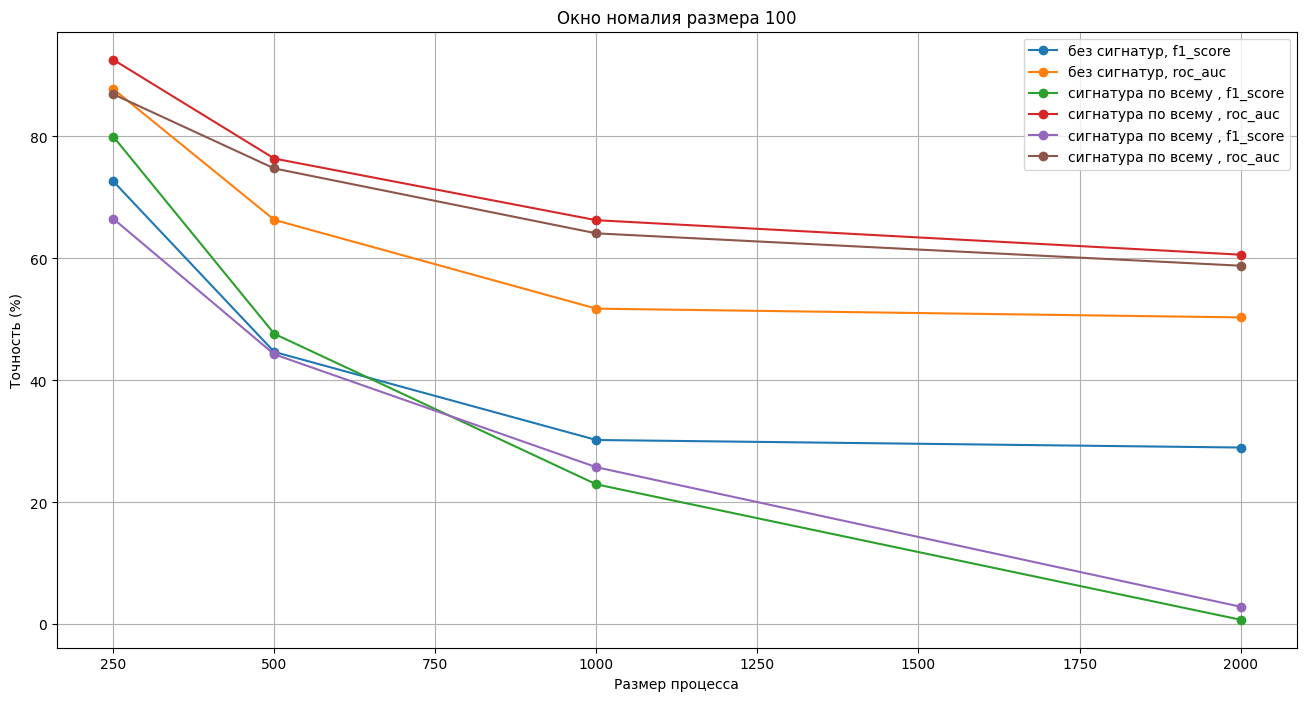

In [95]:
plt.figure(figsize=(16, 8))
for key, arr in avg_no.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"без сигнатур, {key}")
for key, arr in avg_sign.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему , {key}")
for key, arr in avg_win.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему , {key}")
plt.title("Окно номалия размера 100")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

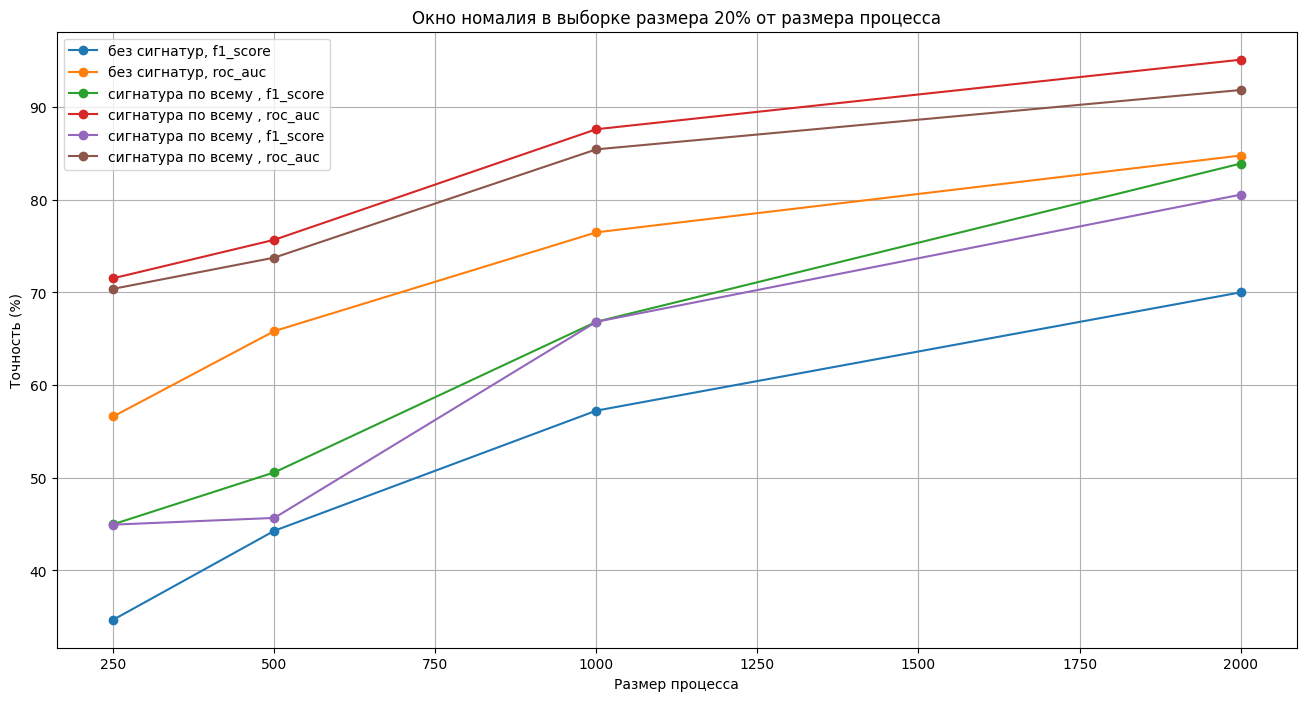

In [93]:
plt.figure(figsize=(16, 8))
for key, arr in avg_no.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"без сигнатур, {key}")
for key, arr in avg_sign.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему , {key}")
for key, arr in avg_win.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему , {key}")
plt.title("Окно номалия в выборке размера 20% от размера процесса")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
agg_no = {key: [] for key in res[0][0].keys()}
agg_sign = {key: [] for key in res[0][1].keys()}
agg_win = {key: [] for key in res[0][2].keys()}

In [15]:
agg_no

{'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'roc_auc': []}

In [24]:
res = [[
  {'accuracy': [66.3, 64.85, 68.89999999999999, 74.85000000000001],
   'precision': [42.65873015873016,
    39.381443298969074,
    47.64957264957265,
    61.3053613053613],
   'recall': [35.833333333333336,
    31.833333333333336,
    37.166666666666664,
    43.833333333333336],
   'f1_score': [38.94927536231884,
    35.20737327188941,
    41.760299625468164,
    51.11758989310009],
   'roc_auc': [63.607261904761906,
    61.3279761904762,
    66.11113095238095,
    74.51232142857143]},
  {'accuracy': [69.75, 71.3, 75.64999999999999, 80.60000000000001],
   'precision': [41.37931034482759,
    73.21428571428571,
    63.68038740920097,
    79.7752808988764],
   'recall': [2.0, 6.833333333333333, 43.833333333333336, 47.333333333333336],
   'f1_score': [3.815580286168521,
    12.499999999999998,
    51.924975320829226,
    59.41422594142259],
   'roc_auc': [66.19357142857143,
    72.45166666666667,
    76.30946428571428,
    86.58964285714286]},
  {'accuracy': [70.0, 71.25, 74.35000000000001, 79.7],
   'precision': [50.0, 59.12408759124088, 59.23566878980891, 70.995670995671],
   'recall': [0.16666666666666669, 13.5, 46.5, 54.666666666666664],
   'f1_score': [0.33222591362126247,
    21.98100407055631,
    52.10084033613446,
    61.77024482109228],
   'roc_auc': [63.00095238095238,
    70.16940476190476,
    74.80059523809524,
    83.26630952380951]}],
 [
  {'accuracy': [64.85, 67.35, 67.10000000000001, 76.1],
   'precision': [40.11516314779271,
    44.53608247422681,
    43.722943722943725,
    62.398373983739845],
   'recall': [34.833333333333336, 36.0, 33.666666666666664, 51.16666666666667],
   'f1_score': [37.28813559322034,
    39.815668202764975,
    38.041431261770256,
    56.227106227106226],
   'roc_auc': [60.98178571428572,
    63.71315476190477,
    62.58869047619048,
    77.6802380952381]},
  {'accuracy': [70.35, 70.65, 74.95, 80.65],
   'precision': [54.21686746987952,
    57.14285714285714,
    75.64766839378238,
    77.66233766233766],
   'recall': [7.5, 8.666666666666668, 24.333333333333336, 49.833333333333336],
   'f1_score': [13.177159590043924,
    15.050651230101304,
    36.82219419924338,
    60.71065989847716],
   'roc_auc': [64.03464285714287,
    68.67357142857145,
    78.48595238095237,
    84.91321428571429]},
  {'accuracy': [70.0, 70.75, 76.1, 75.6],
   'precision': [0.0, 55.24475524475524, 69.18238993710692, 85.44303797468355],
   'recall': [0.0, 13.166666666666666, 36.666666666666664, 22.5],
   'f1_score': [0.0,
    21.265141318977115,
    47.930283224400874,
    35.62005277044855],
   'roc_auc': [60.37083333333333,
    67.94880952380953,
    76.98202380952381,
    80.84238095238095]}],
 [
  {'accuracy': [64.4, 66.35, 67.35, 73.4],
   'precision': [36.473429951690825,
    41.87082405345212,
    44.952380952380956,
    56.93877551020409],
   'recall': [25.166666666666664, 31.333333333333336, 39.33333333333333, 46.5],
   'f1_score': [29.783037475345164,
    35.84366062917064,
    41.955555555555556,
    51.192660550458726],
   'roc_auc': [56.90273809523809,
    61.655357142857135,
    65.16892857142858,
    71.43755952380951]},
  {'accuracy': [70.0, 71.55, 75.85, 79.60000000000001],
   'precision': [0.0, 54.13333333333333, 72.41379310344827, 68.32061068702289],
   'recall': [0.0, 33.83333333333333, 31.5, 59.66666666666667],
   'f1_score': [0.0, 41.64102564102564, 43.90243902439025, 63.70106761565837],
   'roc_auc': [63.66904761904762,
    69.8635119047619,
    77.09178571428572,
    84.78047619047621]},
  {'accuracy': [70.0, 69.6, 75.7, 80.95],
   'precision': [0.0, 48.90710382513661, 72.44094488188976, 73.8562091503268],
   'recall': [0.0, 29.833333333333336, 30.666666666666664, 56.49999999999999],
   'f1_score': [0.0, 37.060041407867494, 43.09133489461358, 64.02266288951841],
   'roc_auc': [61.17214285714285,
    66.5525,
    74.58928571428571,
    84.27428571428571]}]]

In [33]:
data[0].keys()

dict_keys(['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc'])

In [32]:
data = res[0]

In [51]:
data

[{'accuracy': [66.3, 64.85, 68.89999999999999, 74.85000000000001],
  'precision': [42.65873015873016,
   39.381443298969074,
   47.64957264957265,
   61.3053613053613],
  'recall': [35.833333333333336,
   31.833333333333336,
   37.166666666666664,
   43.833333333333336],
  'f1_score': [38.94927536231884,
   35.20737327188941,
   41.760299625468164,
   51.11758989310009],
  'roc_auc': [63.607261904761906,
   61.3279761904762,
   66.11113095238095,
   74.51232142857143]},
 {'accuracy': [69.75, 71.3, 75.64999999999999, 80.60000000000001],
  'precision': [41.37931034482759,
   73.21428571428571,
   63.68038740920097,
   79.7752808988764],
  'recall': [2.0, 6.833333333333333, 43.833333333333336, 47.333333333333336],
  'f1_score': [3.815580286168521,
   12.499999999999998,
   51.924975320829226,
   59.41422594142259],
  'roc_auc': [66.19357142857143,
   72.45166666666667,
   76.30946428571428,
   86.58964285714286]},
 {'accuracy': [70.0, 71.25, 74.35000000000001, 79.7],
  'precision': [50.0,

In [39]:
data[0].items()

dict_items([('accuracy', [66.3, 64.85, 68.89999999999999, 74.85000000000001]), ('precision', [42.65873015873016, 39.381443298969074, 47.64957264957265, 61.3053613053613]), ('recall', [35.833333333333336, 31.833333333333336, 37.166666666666664, 43.833333333333336]), ('f1_score', [38.94927536231884, 35.20737327188941, 41.760299625468164, 51.11758989310009]), ('roc_auc', [63.607261904761906, 61.3279761904762, 66.11113095238095, 74.51232142857143])])

In [40]:
for key, values in data[0].items():
    print(key, values)

accuracy [66.3, 64.85, 68.89999999999999, 74.85000000000001]
precision [42.65873015873016, 39.381443298969074, 47.64957264957265, 61.3053613053613]
recall [35.833333333333336, 31.833333333333336, 37.166666666666664, 43.833333333333336]
f1_score [38.94927536231884, 35.20737327188941, 41.760299625468164, 51.11758989310009]
roc_auc [63.607261904761906, 61.3279761904762, 66.11113095238095, 74.51232142857143]


In [54]:
data = [{
  'f1_score': [0,
   20],
  'roc_auc': [50,
   80]},
 {
  'f1_score': [3,
   40],
  'roc_auc': [80,
   100]}
       ]

In [55]:
data

[{'f1_score': [0, 20], 'roc_auc': [50, 80]},
 {'f1_score': [3, 40], 'roc_auc': [80, 100]}]

In [62]:
agg = {key: np.zeros(len(values)) for key, values in data[0].items()}

In [63]:
agg

{'f1_score': array([0., 0.]), 'roc_auc': array([0., 0.])}

In [64]:
for i in range(len(data)):
    for key, values in data[i].items():
        for j in range(len(values)):
            agg[key][j] += values[j]

In [65]:
agg

{'f1_score': array([ 3., 60.]), 'roc_auc': array([130., 180.])}

In [68]:
for key, values in agg.items():
    for j in range(len(values)):
        values[j] /= len(data)

In [69]:
agg

{'f1_score': array([ 1.5, 30. ]), 'roc_auc': array([65., 90.])}

In [ ]:
def calculate_average_metrics(data):
    agg = {key: np.zeros(len(values)) for key, values in data[0].items()}
    
    for i in range(len(data)):
        for key, values in data[i].items():
            for j in range(len(values)):
                agg[key][j] += values[j]
                
    for key, values in agg.items():
        for j in range(len(values)):
            values[j] /= len(data)
            
    return agg

In [29]:
res[0]

[{'accuracy': [66.3, 64.85, 68.89999999999999, 74.85000000000001],
  'precision': [42.65873015873016,
   39.381443298969074,
   47.64957264957265,
   61.3053613053613],
  'recall': [35.833333333333336,
   31.833333333333336,
   37.166666666666664,
   43.833333333333336],
  'f1_score': [38.94927536231884,
   35.20737327188941,
   41.760299625468164,
   51.11758989310009],
  'roc_auc': [63.607261904761906,
   61.3279761904762,
   66.11113095238095,
   74.51232142857143]},
 {'accuracy': [69.75, 71.3, 75.64999999999999, 80.60000000000001],
  'precision': [41.37931034482759,
   73.21428571428571,
   63.68038740920097,
   79.7752808988764],
  'recall': [2.0, 6.833333333333333, 43.833333333333336, 47.333333333333336],
  'f1_score': [3.815580286168521,
   12.499999999999998,
   51.924975320829226,
   59.41422594142259],
  'roc_auc': [66.19357142857143,
   72.45166666666667,
   76.30946428571428,
   86.58964285714286]},
 {'accuracy': [70.0, 71.25, 74.35000000000001, 79.7],
  'precision': [50.0,

In [51]:
res

[[[250, 500, 1000, 2000],
  {'accuracy': [66.3, 64.85, 68.89999999999999, 74.85000000000001],
   'precision': [42.65873015873016,
    39.381443298969074,
    47.64957264957265,
    61.3053613053613],
   'recall': [35.833333333333336,
    31.833333333333336,
    37.166666666666664,
    43.833333333333336],
   'f1_score': [38.94927536231884,
    35.20737327188941,
    41.760299625468164,
    51.11758989310009],
   'roc_auc': [63.607261904761906,
    61.3279761904762,
    66.11113095238095,
    74.51232142857143]},
  {'accuracy': [69.75, 71.3, 75.64999999999999, 80.60000000000001],
   'precision': [41.37931034482759,
    73.21428571428571,
    63.68038740920097,
    79.7752808988764],
   'recall': [2.0, 6.833333333333333, 43.833333333333336, 47.333333333333336],
   'f1_score': [3.815580286168521,
    12.499999999999998,
    51.924975320829226,
    59.41422594142259],
   'roc_auc': [66.19357142857143,
    72.45166666666667,
    76.30946428571428,
    86.58964285714286]},
  {'accuracy': [70

In [50]:
avg_no, avg_sign, avg_win = calculate_average_metrics(res)
avg_no, avg_sign, avg_win

AxisError: axis 1 is out of bounds for array of dimension 1

In [44]:
avg_no.items()

dict_items([('accuracy', 68.48333333333333), ('precision', 46.83359010075535), ('recall', 37.22222222222222), ('f1_score', 41.43181613734737), ('roc_auc', 65.47392857142857)])

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

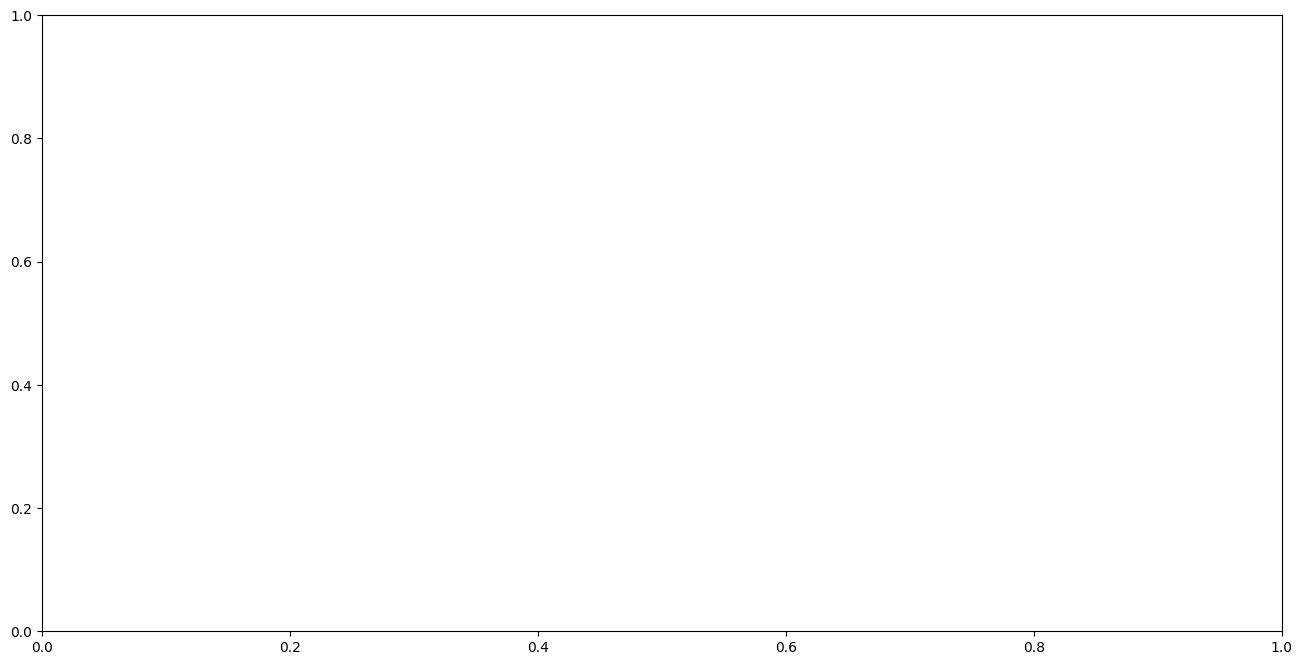

In [45]:
plt.figure(figsize=(16, 8))
n_steps_arr = [250, 500, 1000, 2000]
avg_no, avg_sign, avg_win = calculate_average_metrics(res)
for key, arr in avg_no.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"без сигнатур{i}, {key}")
for key, arr in avg_sign.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по всему {i}, {key}")
for key, arr in avg_win.items():
    if key in ["f1_score", "roc_auc"]:
        plt.plot(n_steps_arr, arr, marker='o', label=f"сигнатура по окну {i}, {key}")
plt.title("Сравнение подходов")
plt.xlabel("Размер процесса")
plt.ylabel("Точность (%)")
plt.legend()
plt.grid(True)
plt.show()